<a href="https://colab.research.google.com/github/Yangxin666/Graph_Autoencoder_Based_Imputation_Summary/blob/main/STGCN_Autoencoders_04_01_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STCGN Autoencoder (STGCN-AE) for PV Data Imputation
An Application of [Spatio-Temporal Graph Neural Networks](https://arxiv.org/pdf/1709.04875.pdf) for imputation

*Structure of our proposed Spatiotemporal Graph Convolutional Neural Networks-based Denoising Autoencoder*

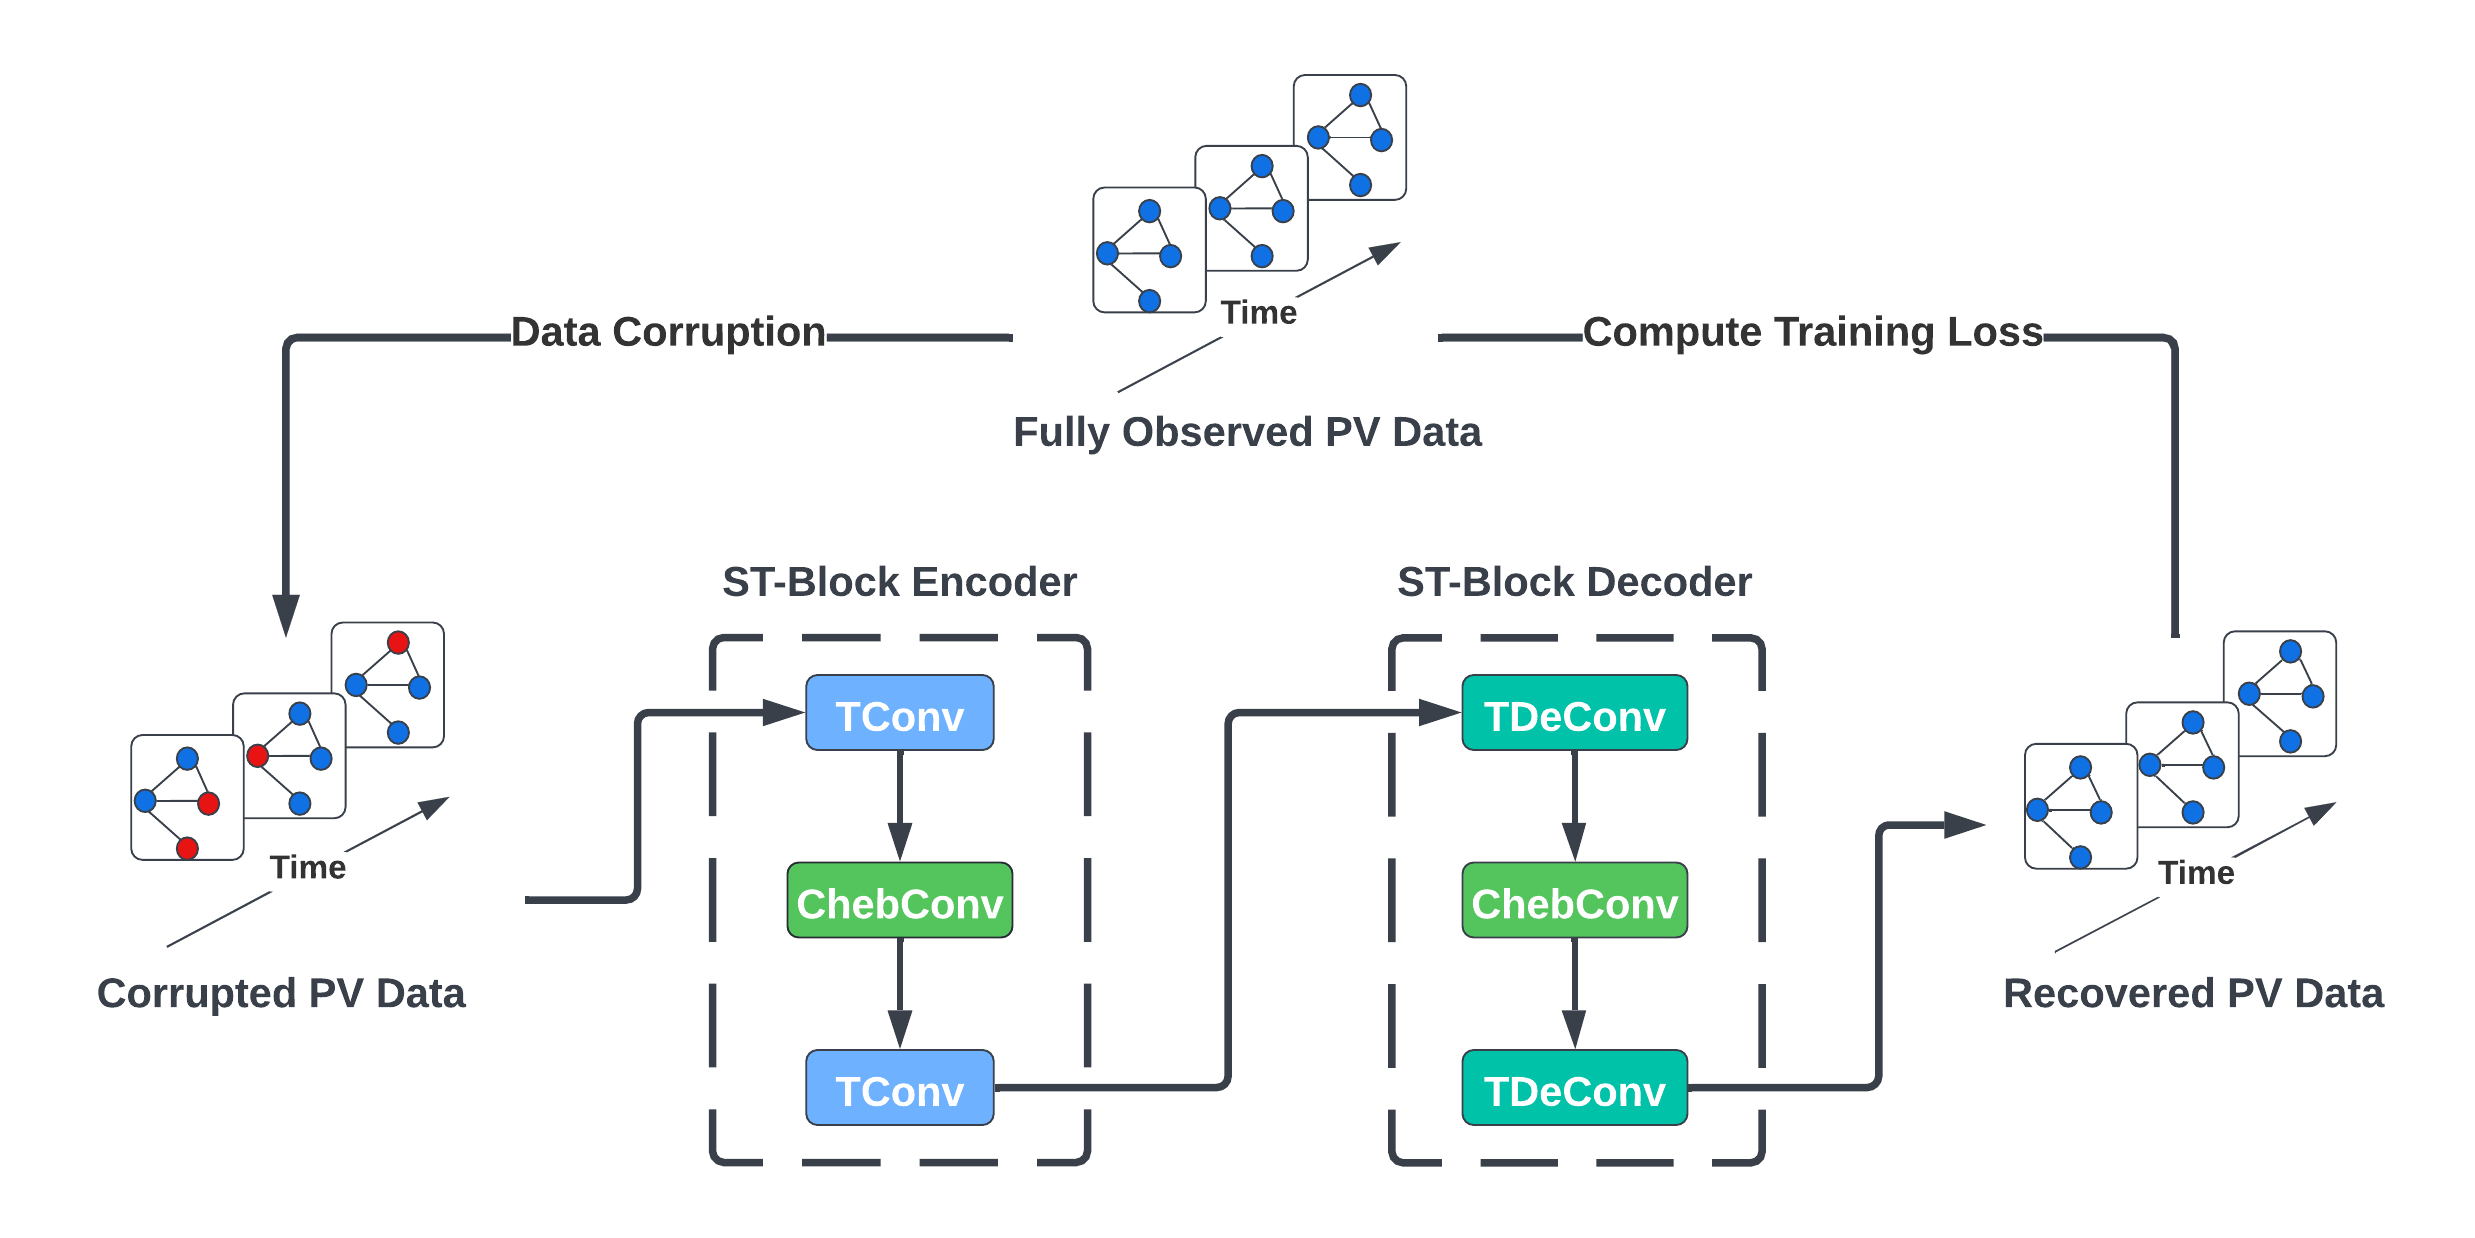

Input: [batch_size, window_size, #nodes, input_channel]

Output: same shape as input, but corrupted parts are recovered

Dataset ranges from 09/01/2015 to 08/25/2016, 360 days in total.

Training: 240 days 

Validation: 60 days

Testing: 60 days


*   Corrupted data X' are generated from fully observed data X using MCAR/Block Missing Mask Generators
*   In the model training, recovered data X'' will be compared with originally fully observed data X to calculate the reconstruction error in the training phase
*   In the model testing, the imputation accuracy is only measured on masked parts of testing data






### Set Up

In [ ]:
# Note that this installation can take a while! Be patient!
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.10.0+${CUDA}.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.10.0+${CUDA}.html
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-1.10.0+${CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.10.0+${CUDA}.html
!pip install torch-geometric
!pip install torch-geometric-temporal

Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+.html


In [ ]:
from datetime import datetime
import geopy.distance # to compute distances between stations
import glob
import numpy as np
import os
import pandas as pd
import scipy.sparse as sp
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
#from torch_geometric_temporal.nn import STConv
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


<a name="part_2"></a>
## 1. Model Building and Training


1.1: Temporal Conv and Deconv Layers

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import ChebConv

class TemporalConv(nn.Module):

    """
    Args:
        in_channels (int): Number of input features.
        out_channels (int): Number of output features.
        kernel_size (int): Convolutional kernel size.
    """

    def __init__(self, in_channels: int, out_channels: int, kernel_size, stride: int, padding: int):
        super(TemporalConv, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels, out_channels, (1, kernel_size), (1, stride), (0,padding))
        self.conv_2 = nn.Conv2d(in_channels, out_channels, (1, kernel_size), (1, stride), (0,padding))
        self.conv_3 = nn.Conv2d(in_channels, out_channels, (1, kernel_size), (1, stride), (0,padding))

    def forward(self, X: torch.FloatTensor) -> torch.FloatTensor:
        """Forward pass through temporal convolution block.

        Arg types:
            * **X** (torch.FloatTensor) -  Input data of shape
                (batch_size, input_time_steps, num_nodes, in_channels).

        Return types:
            * **H** (torch.FloatTensor) - Output data of shape
                (batch_size, in_channels, num_nodes, input_time_steps).
        """
        X = X.permute(0, 3, 2, 1)
        P = self.conv_1(X)
        Q = torch.sigmoid(self.conv_2(X))
        PQ = P * Q
        H = F.relu(PQ + self.conv_3(X))
        H = H.permute(0, 3, 2, 1)
        return H

class TemporalDeConv1(nn.Module):

    """
    Args:
        in_channels (int): Number of input features.
        out_channels (int): Number of output features.
        kernel_size (int): Convolutional kernel size.
    """

    def __init__(self, in_channels: int, out_channels: int, kernel_size, stride: int, padding: int):
        super(TemporalDeConv1, self).__init__()
        self.conv_1 = nn.ConvTranspose2d(in_channels, out_channels, (1, kernel_size), (1, stride), (0,padding))
        self.conv_2 = nn.ConvTranspose2d(in_channels, out_channels, (1, kernel_size),(1, stride), (0,padding))
        self.conv_3 = nn.ConvTranspose2d(in_channels, out_channels, (1, kernel_size),(1, stride), (0,padding))

    def forward(self, X: torch.FloatTensor) -> torch.FloatTensor:
        """Forward pass through temporal convolution block.

        Arg types:
            * **X** (torch.FloatTensor) -  Input data of shape
                (batch_size, input_time_steps, num_nodes, in_channels).

        Return types:
            * **H** (torch.FloatTensor) - Output data of shape
                (batch_size, in_channels, num_nodes, input_time_steps).
        """
        X = X.permute(0, 3, 2, 1)
        P = self.conv_1(X)
        Q = torch.sigmoid(self.conv_2(X))
        PQ = P * Q
        H = F.relu(PQ + self.conv_3(X))
        H = H.permute(0, 3, 2, 1)
        return H

class TemporalDeConv2(nn.Module):

    """
    Args:
        in_channels (int): Number of input features.
        out_channels (int): Number of output features.
        kernel_size (int): Convolutional kernel size.
    """

    def __init__(self, in_channels: int, out_channels: int, kernel_size, stride: int):
        super(TemporalDeConv2, self).__init__()
        self.conv_1 = nn.ConvTranspose2d(in_channels, out_channels, (1, kernel_size),(1, stride))
        self.conv_2 = nn.ConvTranspose2d(in_channels, out_channels, (1, kernel_size),(1, stride))
        self.conv_3 = nn.ConvTranspose2d(in_channels, out_channels, (1, kernel_size),(1, stride))

    def forward(self, X: torch.FloatTensor) -> torch.FloatTensor:
        """Forward pass through temporal convolution block.

        Arg types:
            * **X** (torch.FloatTensor) -  Input data of shape
                (batch_size, input_time_steps, num_nodes, in_channels).

        Return types:
            * **H** (torch.FloatTensor) - Output data of shape
                (batch_size, in_channels, num_nodes, input_time_steps).
        """
        X = X.permute(0, 3, 2, 1)
        P = self.conv_1(X)
        Q = torch.sigmoid(self.conv_2(X))
        PQ = P * Q
        H = F.relu(PQ + self.conv_3(X))
        H = H.permute(0, 3, 2, 1)
        return H

1.2: ST-Block as Encoder & Decode

In [ ]:
class STConvEncoder(nn.Module):

    def __init__(
        self,
        num_nodes: int,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        kernel_size: int,
        stride: int,
        padding: int,
        K: int,
        normalization: str = "sym",
        bias: bool = True,
    ):
        super(STConvEncoder, self).__init__()
        self.num_nodes = num_nodes
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.K = K
        self.normalization = normalization
        self.bias = bias

        self._temporal_conv1 = TemporalConv(
            in_channels=in_channels,
            out_channels=hidden_channels,
            kernel_size=kernel_size, stride = stride, padding = padding,
        )

        self._graph_conv = ChebConv(
            in_channels=hidden_channels,
            out_channels=hidden_channels,
            K=K,
            normalization=normalization,
            bias=bias,
        )

        self._temporal_conv2 = TemporalConv(
            in_channels=hidden_channels,
            out_channels=out_channels,
            kernel_size=kernel_size, stride = stride, padding = padding,
        )

        self._batch_norm = nn.BatchNorm2d(num_nodes)

    def forward(self, X: torch.FloatTensor, edge_index: torch.LongTensor, edge_weight: torch.FloatTensor = None,) -> torch.FloatTensor:

        r"""Forward pass. If edge weights are not present the forward pass
        defaults to an unweighted graph.

        Arg types:
            * **X** (PyTorch FloatTensor) - Sequence of node features of shape (Batch size X Input time steps X Num nodes X In channels).
            * **edge_index** (PyTorch LongTensor) - Graph edge indices.
            * **edge_weight** (PyTorch LongTensor, optional)- Edge weight vector.

        Return types:
            * **T** (PyTorch FloatTensor) - Sequence of node features.
        """
        #print(X.shape)
        T_0 = self._temporal_conv1(X)
        #print(T_0.shape)
        T = torch.zeros_like(T_0).to(T_0.device)
        for b in range(T_0.size(0)):
            for t in range(T_0.size(1)):
                T[b][t] = self._graph_conv(T_0[b][t], edge_index, edge_weight)

        T = F.relu(T)
        #print(T.shape)
        T = self._temporal_conv2(T)
        #print(T.shape)
        # T = T.permute(0, 2, 1, 3)
        # #print(T.shape)
        # T = self._batch_norm(T)
        # T = T.permute(0, 2, 1, 3)
        #print(T.shape)

        return T

In [ ]:
class STConvDecoder(nn.Module):

    def __init__(
        self,
        num_nodes: int,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        kernel_size: int,
        kernel_size_de: int,
        stride: int,
        padding: int,
        K: int,
        normalization: str = "sym",
        bias: bool = True,
    ):
        super(STConvDecoder, self).__init__()
        self.num_nodes = num_nodes
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.K = K
        self.normalization = normalization
        self.bias = bias

        self._temporal_conv1 = TemporalDeConv1(
            in_channels=in_channels,
            out_channels=hidden_channels,
            kernel_size=kernel_size, stride = stride, padding = padding,
        )

        self._graph_conv = ChebConv(
            in_channels=hidden_channels,
            out_channels=hidden_channels,
            K=K,
            normalization=normalization,
            bias=bias,
        )

        self._temporal_conv2 = TemporalDeConv2(
            in_channels=hidden_channels,
            out_channels=out_channels,
            kernel_size=kernel_size_de, stride = stride,
        )

        self._batch_norm = nn.BatchNorm2d(num_nodes)

    def forward(self, X: torch.FloatTensor, edge_index: torch.LongTensor, edge_weight: torch.FloatTensor = None,) -> torch.FloatTensor:

        r"""Forward pass. If edge weights are not present the forward pass
        defaults to an unweighted graph.

        Arg types:
            * **X** (PyTorch FloatTensor) - Sequence of node features of shape (Batch size X Input time steps X Num nodes X In channels).
            * **edge_index** (PyTorch LongTensor) - Graph edge indices.
            * **edge_weight** (PyTorch LongTensor, optional)- Edge weight vector.

        Return types:
            * **T** (PyTorch FloatTensor) - Sequence of node features.
        """
        T_0 = self._temporal_conv1(X)
        T = torch.zeros_like(T_0).to(T_0.device)
        for b in range(T_0.size(0)):
            for t in range(T_0.size(1)):
                T[b][t] = self._graph_conv(T_0[b][t], edge_index, edge_weight)

        T = F.relu(T)
        T = self._temporal_conv2(T)
        # T = T.permute(0, 2, 1, 3)
        # T = self._batch_norm(T)
        # T = T.permute(0, 2, 1, 3)
        return T

1.3: STGCN Denoising Autoencoder

In [ ]:
# final model
# a specified number of STConv blocks, followed by an output layer
class STConvAE(torch.nn.Module):
    def __init__(self, device, num_nodes, channel_size_list, num_layers, 
                 kernel_size, K, window_size, kernel_size_de, stride, padding,\
                 normalization = 'sym', bias = True):
    # num_nodes = number of nodes in the input graph
    # channel_size_list =  2d array representing feature dimensions throughout the model
    # num_layers = number of STConv blocks
    # kernel_size = length of the temporal kernel
    # K = size of the chebyshev filter for the spatial convolution
    # window_size = number of historical time steps to consider

        super(STConvAE, self).__init__()
        self.layers = nn.ModuleList([])
        # add STConv blocks
        for l in range(num_layers):
            input_size, hidden_size, output_size = channel_size_list[l][0], channel_size_list[l][1], channel_size_list[l][2]
            if l==0:
              self.layers.append(STConvEncoder(num_nodes, input_size, hidden_size, output_size, kernel_size, stride, padding, K, normalization, bias))
            if l==1:
              self.layers.append(STConvDecoder(num_nodes, input_size, hidden_size, output_size, kernel_size, kernel_size_de, stride, padding, K, normalization, bias))
        

        # # add output layer
        # self.layers.append(OutputLayer(channel_size_list[-1][-1], \
        #                                window_size - 2 * num_layers * (kernel_size - 1), \
        #                                num_nodes))
        # CUDA if available
        for layer in self.layers:
            layer = layer.to(device)

    def forward(self, x, edge_index, edge_weight ):
        #print(x.shape)
        for layer in self.layers:
          x = layer(x, edge_index, edge_weight)
          #print(x.shape)
        # out_layer = self.layers[-1]
        # x = x.permute(0, 3, 1, 2)
        # x = out_layer(x)
        # print(x.shape)
        return x

### 2. Model Training



#2.1: Define Parameters

In [ ]:
# model parameters
num_nodes = 98
#channels = np.array([[1, 1, 1], [1, 1, 1]]) # sequence of channel sizes
channels = np.array([[1, 4, 8], [8, 4, 1]])
kernel_size = 4 # size of temporal kernel
kernel_size_de = 2 # size of temporal deconv2
stride = 2
padding = 1
K = 3 # chebyshev filter size

# training parameters
learning_rate = 0.001
batch_size = 2
num_epochs = 50 # note that we trained for 7 epochs using Google Cloud
num_layers = 2 # number of STConv blocks
n_his = 288 # window size
train_prop = 2/3 # Our actual training set proportion was 0.7
val_prop = 1/6 # Our actual training set proportion was 0.2
test_prop = 1/6 # Our actual training set proportion was 0.1

# model save path
model_save_path = os.path.join(
    'gdrive', 'MyDrive', 'STGCN', 'best_model.pt')

2.2: Data Preparation

In [ ]:
def data_transform(data, corrupted_data, window, device):
    # data = slice of V matrix
    # n_his = number of historical speed observations to consider
    # n_pred = number of time steps in the future to predict

    num_nodes = data.shape[1]
    num_obs = int(len(data)/window)
    x = np.zeros([num_obs, window, num_nodes, 1])
    y = np.zeros([num_obs, window, num_nodes, 1])
    
    obs_idx = 0
    for i in range(num_obs):
        head = i*window
        tail = (i+1)*window
        y[obs_idx, :, :, :] = data[head: tail].reshape(n_his, num_nodes, 1)
        x[obs_idx, :, :, :] = corrupted_data[head: tail].reshape(n_his, num_nodes, 1)
        #x[obs_idx, :, :, :] = data[head: tail].reshape(n_his, num_nodes, 1)
        obs_idx += 1

    return torch.Tensor(x).to(device), torch.Tensor(y).to(device)

Now let's go ahead and convert our processed data into a form we can use to train our model.

In [ ]:
W = pd.read_csv('gdrive/My Drive/STGCN/W_98.csv')
V = pd.read_csv('gdrive/My Drive/STGCN/norm_power.csv')
#V = V.iloc[:,:103680]
V = V.T.interpolate(method ='linear', limit_direction ='forward')
V

,0,1,2,3,4,5,6,7,8,9,...,88,89,90,91,92,93,94,95,96,97
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103675,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
min(np.min(V))

-0.4012962400702

# 2.2: Missing Value Injection

#MCAR

In [ ]:
mask = torch.FloatTensor(103680, 8).uniform_() > 0.4
pd.DataFrame(mask.numpy()).to_csv('gdrive/My Drive/STGCN/40%MCAR_8.csv',index=False)

#Block Missing

In [ ]:
import random
np.random.randint(0,98,10)

array([ 0, 53, 33, 22,  5, 52,  0, 23, 57, 78])

[0, 288] a day interval
inject 98 interval as a mask randomly
12 hours
6AM - 2PM 

1. Variance of MAE/RMSE for baseline vs. GCN-AE
2. GCN-AE robustness compared with other methods

Construct edges based on inbound (adaptive)

In [ ]:
import random
#nb_interval=0
missing_percent = 0.25
#length=int(3456*0.2)
length=72
limit_low=0
limit_high=69120
mask = torch.full((103680,98), True)
num = int(missing_percent*3456/length)
for i in range(360):
  for j in range(98):
    number = random.randint(288*i+1,288*(i+1)-length-1)
    mask[number:number+length, j] = False

pd.DataFrame(mask.numpy()).to_csv('gdrive/My Drive/STGCN/25%BM_360days_98_2.csv',index=False)
# Plants = np.random.randint(0,98,7)
# print(Plants)
# for i in Plants:
#   for j in range(240):
#     start = 288*j+48
#     end = 288*j+240
#     mask[start:end, i] = False


#pd.DataFrame(mask.numpy()).to_csv('gdrive/My Drive/STGCN/Plants_corrupted.csv',index=False)

In [ ]:
mask = pd.read_csv('gdrive/My Drive/STGCN/25%BM_360days_98_2.csv')
mask = torch.tensor(mask.values)
V_corrupted = pd.read_csv('gdrive/My Drive/STGCN/norm_power.csv')
V_corrupted = V_corrupted.iloc[:,:103680]
V_corrupted = V_corrupted.T.interpolate(method ='linear', limit_direction ='forward')
V_corrupted[mask.numpy()==False] = -1
V_corrupted

,0,1,2,3,4,5,6,7,8,9,...,88,89,90,91,92,93,94,95,96,97
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103675,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
wspa_tensor = torch.tensor(V.values)
length = V.shape[0]
train_x = wspa_tensor[0:int(train_prop*length),:].to(torch.float32)
validation_x = wspa_tensor[int(train_prop*length):int((train_prop+val_prop)*length)+1,:].to(torch.float32)
test_x = wspa_tensor[int((train_prop+val_prop)*length)+1:length,:].to(torch.float32)

wspa_corrupted_tensor = torch.tensor(V_corrupted.values)
length = V_corrupted.shape[0]
corrupted_train_x = wspa_corrupted_tensor[0:int(train_prop*length),:].to(torch.float32)
corrupted_validation_x = wspa_corrupted_tensor[int(train_prop*length):int((train_prop+val_prop)*length)+1,:].to(torch.float32)
corrupted_test_x = wspa_corrupted_tensor[int((train_prop+val_prop)*length)+1:length,:].to(torch.float32)

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() \
else torch.device("cpu")

x_train, y_train = data_transform(train_x.numpy(), corrupted_train_x.numpy(), n_his, device)
x_val, y_val = data_transform(validation_x.numpy(), corrupted_validation_x.numpy(), n_his, device)
x_test, y_test = data_transform(test_x.numpy(), corrupted_test_x.numpy(), n_his, device)

# create torch data iterables for training
train_data = torch.utils.data.TensorDataset(x_train, y_train)
train_iter = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
val_data = torch.utils.data.TensorDataset(x_val, y_val)
val_iter = torch.utils.data.DataLoader(val_data, batch_size)
test_data = torch.utils.data.TensorDataset(x_test, y_test)
test_iter = torch.utils.data.DataLoader(test_data, batch_size)

# format graph for pyg layer inputs
G = sp.coo_matrix(W)
edge_index = torch.tensor(np.array([G.row, G.col]), dtype=torch.int64).to(device)
edge_weight = torch.tensor(G.data).float().to(device)

#2.3: Model Training

First let's initialize our model and define our loss and optimizer. Our loss function will be MSE loss, and we'll use an Adam optimizer.

In [ ]:
model = STConvAE(device, num_nodes, channels, num_layers, kernel_size, K, n_his, kernel_size_de, stride, padding, normalization = 'sym', bias = True).to(device)
# define loss function
loss = nn.MSELoss()
# define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = 0.02) 

In [24]:
min_valid_loss = np.inf

for epoch in tqdm(range(1, num_epochs + 1), desc = 'Epoch', position = 0):
  train_loss, n = 0.0, 0
  model.train()

  for x, y in tqdm(train_iter, desc = 'Batch', position = 0):
    # get model predictions and compute loss
    y_pred = model(x.to(device), edge_index, edge_weight)
    #pred = y_pred[x.cpu().numpy()==-40]
    #ground_truth = y[x.cpu().numpy()==-40]
    #l = loss(y_pred, y)
    #loss = torch.mean((pred-ground_truth)**2)
    loss = torch.mean((y_pred-y)**2)
    # backpropogation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #print("Loss is:"+ str(loss))
    train_loss += loss.item()

  valid_loss = 0.0
  model.eval() 
  for x, y in tqdm(val_iter, desc = 'Batch', position = 0):
    # get model predictions and compute loss
    y_pred = model(x.to(device), edge_index, edge_weight)
    #pred = y_pred[x.cpu().numpy()==-40]
    #ground_truth = y[x.cpu().numpy()==-40]
    #l = loss(y_pred, y)
    #loss = torch.mean((pred-ground_truth)**2)
    #l = loss(y_pred, y)
    loss = torch.mean((y_pred-y)**2)
    valid_loss += loss.item() 

  print(f'Epoch {epoch} \t\t Training Loss: {train_loss/120} \t\t Validation Loss: {valid_loss/30}')
  if min_valid_loss > valid_loss:
    min_valid_loss = valid_loss
    torch.save(model.state_dict(), model_save_path)

Batch: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s]


Epoch 1 		 Training Loss: 250.3382489701112 		 Validation Loss: 50.51292031606038


Epoch:   4%|▍         | 2/50 [05:14<2:05:36, 157.01s/it]

Epoch 2 		 Training Loss: 19.635304953654607 		 Validation Loss: 29.569601090749106


Epoch:   6%|▌         | 3/50 [07:50<2:02:42, 156.65s/it]

Epoch 3 		 Training Loss: 13.753390194972356 		 Validation Loss: 23.340417416890464


Epoch:   8%|▊         | 4/50 [10:27<2:00:11, 156.76s/it]

Epoch 4 		 Training Loss: 11.405868178606033 		 Validation Loss: 20.756790971755983


Epoch:  10%|█         | 5/50 [13:04<1:57:34, 156.77s/it]

Epoch 5 		 Training Loss: 10.166482821355263 		 Validation Loss: 19.078382619222005


Epoch:  12%|█▏        | 6/50 [15:42<1:55:21, 157.31s/it]

Epoch 6 		 Training Loss: 9.366053681572279 		 Validation Loss: 17.924451939264934


Epoch:  14%|█▍        | 7/50 [18:19<1:52:37, 157.15s/it]

Epoch 7 		 Training Loss: 8.807618406414985 		 Validation Loss: 16.943784880638123


Epoch:  16%|█▌        | 8/50 [20:55<1:49:50, 156.91s/it]

Epoch 8 		 Training Loss: 8.354566804567973 		 Validation Loss: 16.394658533732095


Epoch:  18%|█▊        | 9/50 [23:32<1:47:16, 156.98s/it]

Epoch 9 		 Training Loss: 8.031617447733879 		 Validation Loss: 15.691150172551472


Epoch:  20%|██        | 10/50 [26:09<1:44:38, 156.97s/it]

Epoch 10 		 Training Loss: 7.781494920576612 		 Validation Loss: 15.31540675163269


Epoch:  22%|██▏       | 11/50 [28:46<1:42:00, 156.94s/it]

Epoch 11 		 Training Loss: 7.502912400414546 		 Validation Loss: 14.920711334546407


Epoch:  24%|██▍       | 12/50 [31:23<1:39:17, 156.79s/it]

Epoch 12 		 Training Loss: 7.300993146623174 		 Validation Loss: 14.468822105725605


Epoch:  26%|██▌       | 13/50 [33:59<1:36:31, 156.53s/it]

Epoch 13 		 Training Loss: 7.105618295570214 		 Validation Loss: 14.220229864120483


Epoch:  28%|██▊       | 14/50 [36:35<1:33:57, 156.61s/it]

Epoch 14 		 Training Loss: 6.89950656319658 		 Validation Loss: 13.753941520055134


Epoch:  30%|███       | 15/50 [39:12<1:31:21, 156.62s/it]

Epoch 15 		 Training Loss: 6.839329913879435 		 Validation Loss: 14.570813735326132


Epoch:  32%|███▏      | 16/50 [41:49<1:28:42, 156.55s/it]

Epoch 16 		 Training Loss: 6.566176785031955 		 Validation Loss: 14.833052015304565


Epoch:  34%|███▍      | 17/50 [44:25<1:26:01, 156.42s/it]

Epoch 17 		 Training Loss: 6.394397170841694 		 Validation Loss: 12.519038653373718


Epoch:  36%|███▌      | 18/50 [47:01<1:23:25, 156.42s/it]

Epoch 18 		 Training Loss: 6.1502656621237595 		 Validation Loss: 12.619736591974894


Epoch:  38%|███▊      | 19/50 [49:37<1:20:44, 156.29s/it]

Epoch 19 		 Training Loss: 5.93489444454511 		 Validation Loss: 11.782745091120402


Epoch:  40%|████      | 20/50 [52:13<1:18:09, 156.32s/it]

Epoch 20 		 Training Loss: 5.741668274005254 		 Validation Loss: 11.411027065912883


Epoch:  42%|████▏     | 21/50 [54:50<1:15:33, 156.32s/it]

Epoch 21 		 Training Loss: 5.613578535119692 		 Validation Loss: 11.353045566876729


Epoch:  44%|████▍     | 22/50 [57:26<1:12:58, 156.36s/it]

Epoch 22 		 Training Loss: 5.451215473810832 		 Validation Loss: 10.776508180300395


Epoch:  46%|████▌     | 23/50 [1:00:03<1:10:22, 156.40s/it]

Epoch 23 		 Training Loss: 5.214489332586527 		 Validation Loss: 10.555183386802673


Epoch:  48%|████▊     | 24/50 [1:02:44<1:08:22, 157.79s/it]

Epoch 24 		 Training Loss: 5.159637599190076 		 Validation Loss: 10.271433941523235


Epoch:  50%|█████     | 25/50 [1:05:20<1:05:29, 157.19s/it]

Epoch 25 		 Training Loss: 5.177467590073745 		 Validation Loss: 9.974564401308696


Epoch:  52%|█████▏    | 26/50 [1:07:54<1:02:33, 156.39s/it]

Epoch 26 		 Training Loss: 4.836993517975013 		 Validation Loss: 9.73428175052007


Epoch:  54%|█████▍    | 27/50 [1:10:30<59:55, 156.33s/it]  

Epoch 27 		 Training Loss: 4.764248949289322 		 Validation Loss: 9.668760895729065


Epoch:  56%|█████▌    | 28/50 [1:13:07<57:24, 156.56s/it]

Epoch 28 		 Training Loss: 4.80591385687391 		 Validation Loss: 11.144941075642903


Epoch:  58%|█████▊    | 29/50 [1:15:44<54:48, 156.59s/it]

Epoch 29 		 Training Loss: 4.542287741601467 		 Validation Loss: 9.319742317994436


Epoch:  60%|██████    | 30/50 [1:18:20<52:10, 156.52s/it]

Epoch 30 		 Training Loss: 4.5575075392921764 		 Validation Loss: 9.317164929707845


Epoch:  62%|██████▏   | 31/50 [1:20:57<49:36, 156.64s/it]

Epoch 31 		 Training Loss: 4.469864986588558 		 Validation Loss: 9.460705840587616


Epoch:  64%|██████▍   | 32/50 [1:23:35<47:04, 156.92s/it]

Epoch 32 		 Training Loss: 4.406444683670998 		 Validation Loss: 9.20530922015508


Epoch:  66%|██████▌   | 33/50 [1:26:12<44:26, 156.86s/it]

Epoch 33 		 Training Loss: 4.339837358146906 		 Validation Loss: 9.053281021118163


Epoch:  68%|██████▊   | 34/50 [1:28:47<41:45, 156.57s/it]

Epoch 34 		 Training Loss: 4.512250898033381 		 Validation Loss: 9.138435411453248


Epoch:  70%|███████   | 35/50 [1:31:24<39:08, 156.60s/it]

Epoch 35 		 Training Loss: 4.310284209872285 		 Validation Loss: 8.961873702208202


Epoch:  72%|███████▏  | 36/50 [1:33:59<36:25, 156.10s/it]

Epoch 36 		 Training Loss: 4.3666455457607904 		 Validation Loss: 8.968045417467753


Epoch:  74%|███████▍  | 37/50 [1:36:35<33:50, 156.16s/it]

Epoch 37 		 Training Loss: 4.324343662615865 		 Validation Loss: 8.895452686150868


Epoch:  76%|███████▌  | 38/50 [1:39:11<31:13, 156.14s/it]

Epoch 38 		 Training Loss: 4.243200057248274 		 Validation Loss: 8.906212198734284


Epoch:  78%|███████▊  | 39/50 [1:41:47<28:36, 156.03s/it]

Epoch 39 		 Training Loss: 4.291233282287916 		 Validation Loss: 8.982912806669871


Epoch:  80%|████████  | 40/50 [1:44:32<26:27, 158.70s/it]

Epoch 40 		 Training Loss: 4.2608362051347894 		 Validation Loss: 8.912972939014434


Epoch:  82%|████████▏ | 41/50 [1:47:25<24:27, 163.09s/it]

Epoch 41 		 Training Loss: 4.1790045286218325 		 Validation Loss: 8.735757299264272


Epoch:  84%|████████▍ | 42/50 [1:50:19<22:10, 166.27s/it]

Epoch 42 		 Training Loss: 4.185500906780362 		 Validation Loss: 9.168530503908793


Epoch:  86%|████████▌ | 43/50 [1:53:14<19:40, 168.70s/it]

Epoch 43 		 Training Loss: 4.300819783657789 		 Validation Loss: 8.986472916603088


Epoch:  88%|████████▊ | 44/50 [1:56:06<16:59, 169.91s/it]

Epoch 44 		 Training Loss: 4.160385391457627 		 Validation Loss: 8.790322776635488


Epoch:  90%|█████████ | 45/50 [1:58:59<14:13, 170.79s/it]

Epoch 45 		 Training Loss: 4.08787294626236 		 Validation Loss: 8.642902938524882


Epoch:  92%|█████████▏| 46/50 [2:01:52<11:26, 171.56s/it]

Epoch 46 		 Training Loss: 4.0851942070759835 		 Validation Loss: 8.764366773764293


Epoch:  94%|█████████▍| 47/50 [2:04:47<08:37, 172.35s/it]

Epoch 47 		 Training Loss: 4.0389699213206764 		 Validation Loss: 8.514176110426584


Epoch:  96%|█████████▌| 48/50 [2:07:39<05:44, 172.24s/it]

Epoch 48 		 Training Loss: 4.092075794065992 		 Validation Loss: 9.060093855857849


Epoch:  98%|█████████▊| 49/50 [2:10:30<02:52, 172.12s/it]

Epoch 49 		 Training Loss: 4.030505893876155 		 Validation Loss: 8.500363488992056


Epoch: 100%|██████████| 50/50 [2:13:23<00:00, 160.06s/it]

Epoch 50 		 Training Loss: 4.033490188637128 		 Validation Loss: 8.528045992056528


#3. Evaluate Model
Now let's see how it performed on the test set.

In [25]:
# load model with lowest validation lost
best_model = STConvAE(device, num_nodes, channels, num_layers, kernel_size, K, n_his, kernel_size_de, stride, padding, normalization = 'sym', bias = True).to(device)
best_model.load_state_dict(torch.load(model_save_path))

best_model.eval()
cost = 0
missing_count = 0
predicted = []
ground_truth = []

i = 1

for x, y in tqdm(test_iter, desc = 'Batch', position = 0):
    # get model predictions and compute loss
    y_pred = best_model(x.to(device), edge_index, edge_weight)
    if i == 1:
      y_pred_complete = y_pred
    else:
      y_pred_complete = torch.cat((y_pred_complete, y_pred), 0)
    i+=1

print(y_pred_complete.shape)

Batch: 100%|██████████| 30/30 [00:32<00:00,  1.09s/it]

torch.Size([60, 288, 98, 1])


In [26]:
pred = y_pred_complete[x_test.numpy()==-1]
ground_truth = y_test[x_test.numpy()==-1]
print("Test MSE of STGCN-AE is: "+ str(torch.mean((pred-ground_truth)**2)))
print("Test MAE is of STGCN-AE is: "+ str(torch.mean(abs(pred-ground_truth))))

Test MSE of STGCN-AE is: tensor(33.8283, grad_fn=<MeanBackward0>)
Test MAE is of STGCN-AE is: tensor(2.0135, grad_fn=<MeanBackward0>)


In [27]:
#Linear Interpolation
corrupted_test_x[corrupted_test_x==-1] = np.nan
test = pd.DataFrame(corrupted_test_x.numpy())
LI_imputed = test.interpolate(method ='linear', limit_direction ='forward')
#LI_imputed = LI_imputed.dropna()
LI_imputed = LI_imputed.fillna(LI_imputed.mean())
LI_imputed = torch.tensor(LI_imputed.values)
LI_pred = LI_imputed[~mask[86400:103680,]]
print("Test MSE of Linear Interpolation is: "+ str(torch.mean((LI_pred.cpu()-ground_truth.cpu())**2)))
print("Test MAE of Linear Interpolation is: "+ str(torch.mean(abs(LI_pred.cpu()-ground_truth.cpu()))))

Test MSE of Linear Interpolation is: tensor(242.5953)
Test MAE of Linear Interpolation is: tensor(11.6193)


In [28]:
#Mean Imputation
corrupted_test_x[corrupted_test_x==-1] = np.nan
test = pd.DataFrame(corrupted_test_x.numpy())
Mean_imputed = test.fillna(test.mean())
Mean_imputed = torch.tensor(Mean_imputed.values)
Mean_pred = Mean_imputed[~mask[86400:103680,]]
print("Test MSE of Mean Imputation is: "+ str(torch.mean((Mean_pred.cpu()-ground_truth.cpu())**2)))
print("Test MAE of Mean Imputation is: "+ str(torch.mean(abs(Mean_pred.cpu()-ground_truth.cpu()))))

Test MSE of Mean Imputation is: tensor(837.1801)
Test MAE of Mean Imputation is: tensor(23.6736)


In [ ]:
!pip install fancyimpute

     |████████████████████████████████| 154 kB 6.5 MB/s 
  Created wheel for fancyimpute: filename=fancyimpute-0.7.0-py3-none-any.whl size=29899 sha256=d470ce93060081b7a051c30f470a9523e431685f55ca9cfb1df1c13e177a82c0
  Stored in directory: /root/.cache/pip/wheels/e3/04/06/a1a7d89ef4e631ce6268ea2d8cde04f7290651c1ff1025ce68
  Created wheel for knnimpute: filename=knnimpute-0.1.0-py3-none-any.whl size=11353 sha256=6713b4bd7efabf18a41fbd5d927ab15101665a105b758b6c7652f99767cd37c8
  Stored in directory: /root/.cache/pip/wheels/72/21/a8/a045cacd9838abd5643f6bfa852c0796a99d6b1494760494e0
Successfully built fancyimpute knnimpute


In [30]:
#MICE
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

# knn = KNeighborsRegressor()
imp = IterativeImputer(initial_strategy = 'median', imputation_order='ascending',random_state=42)
corrupted_train_x[corrupted_train_x==-1] = np.nan
train = pd.DataFrame(corrupted_train_x.numpy())
imp.fit(train)
MICE_imputed = imp.transform(test)
MICE_imputed = pd.DataFrame(MICE_imputed)
MICE_imputed = torch.tensor(MICE_imputed.values)
MICE_pred = MICE_imputed[~mask[86400:103680,]]
print("Test MSE of MICE Interpolation is: "+ str(torch.mean((MICE_pred.cpu()-ground_truth.cpu())**2)))
print("Test MAE of MICE Interpolation is: "+ str(torch.mean(abs(MICE_pred.cpu()-ground_truth.cpu()))))

/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


Test MSE of MICE Interpolation is: tensor(32.1532)
Test MAE of MICE Interpolation is: tensor(2.2252)


In [31]:
# import the KNNimputer class
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)
imputer.fit(train)
KNN_imputed = imputer.transform(test)
KNN_imputed = pd.DataFrame(KNN_imputed)
KNN_imputed = torch.tensor(KNN_imputed.values)
KNN_pred = KNN_imputed[~mask[86400:103680,]]
print("Test MSE of KNN Interpolation is: "+ str(torch.mean((KNN_pred.cpu()-ground_truth.cpu())**2)))
print("Test MAE of KNN Interpolation is: "+ str(torch.mean(abs(KNN_pred.cpu()-ground_truth.cpu()))))

Test MSE of KNN Interpolation is: tensor(51.8551)
Test MAE of KNN Interpolation is: tensor(3.2569)


# Visualization

In [61]:
MICE_imputed.shape

torch.Size([17280, 98])

In [56]:
example = torch.squeeze(y_pred_complete[0])
example = pd.DataFrame(example.detach().numpy())
example.to_excel('gdrive/My Drive/STGCN/MICE_pred.xlsx',index=False)

In [66]:
example = pd.DataFrame(LI_imputed.detach().numpy())
example = example.iloc[:288,:]
example.to_excel('gdrive/My Drive/STGCN/LI_pred.xlsx',index=False)

In [57]:
example_T = torch.squeeze(y_test[0])
example_T = pd.DataFrame(example_T.detach().numpy())
example_T.to_excel('gdrive/My Drive/STGCN/example_ground_truth.xlsx',index=False)

In [59]:
example_c = pd.DataFrame(corrupted_test_x.detach().numpy())
example_c = example_c.iloc[:288,:]
example_c.to_excel('gdrive/My Drive/STGCN/example_corrupted.xlsx',index=False)

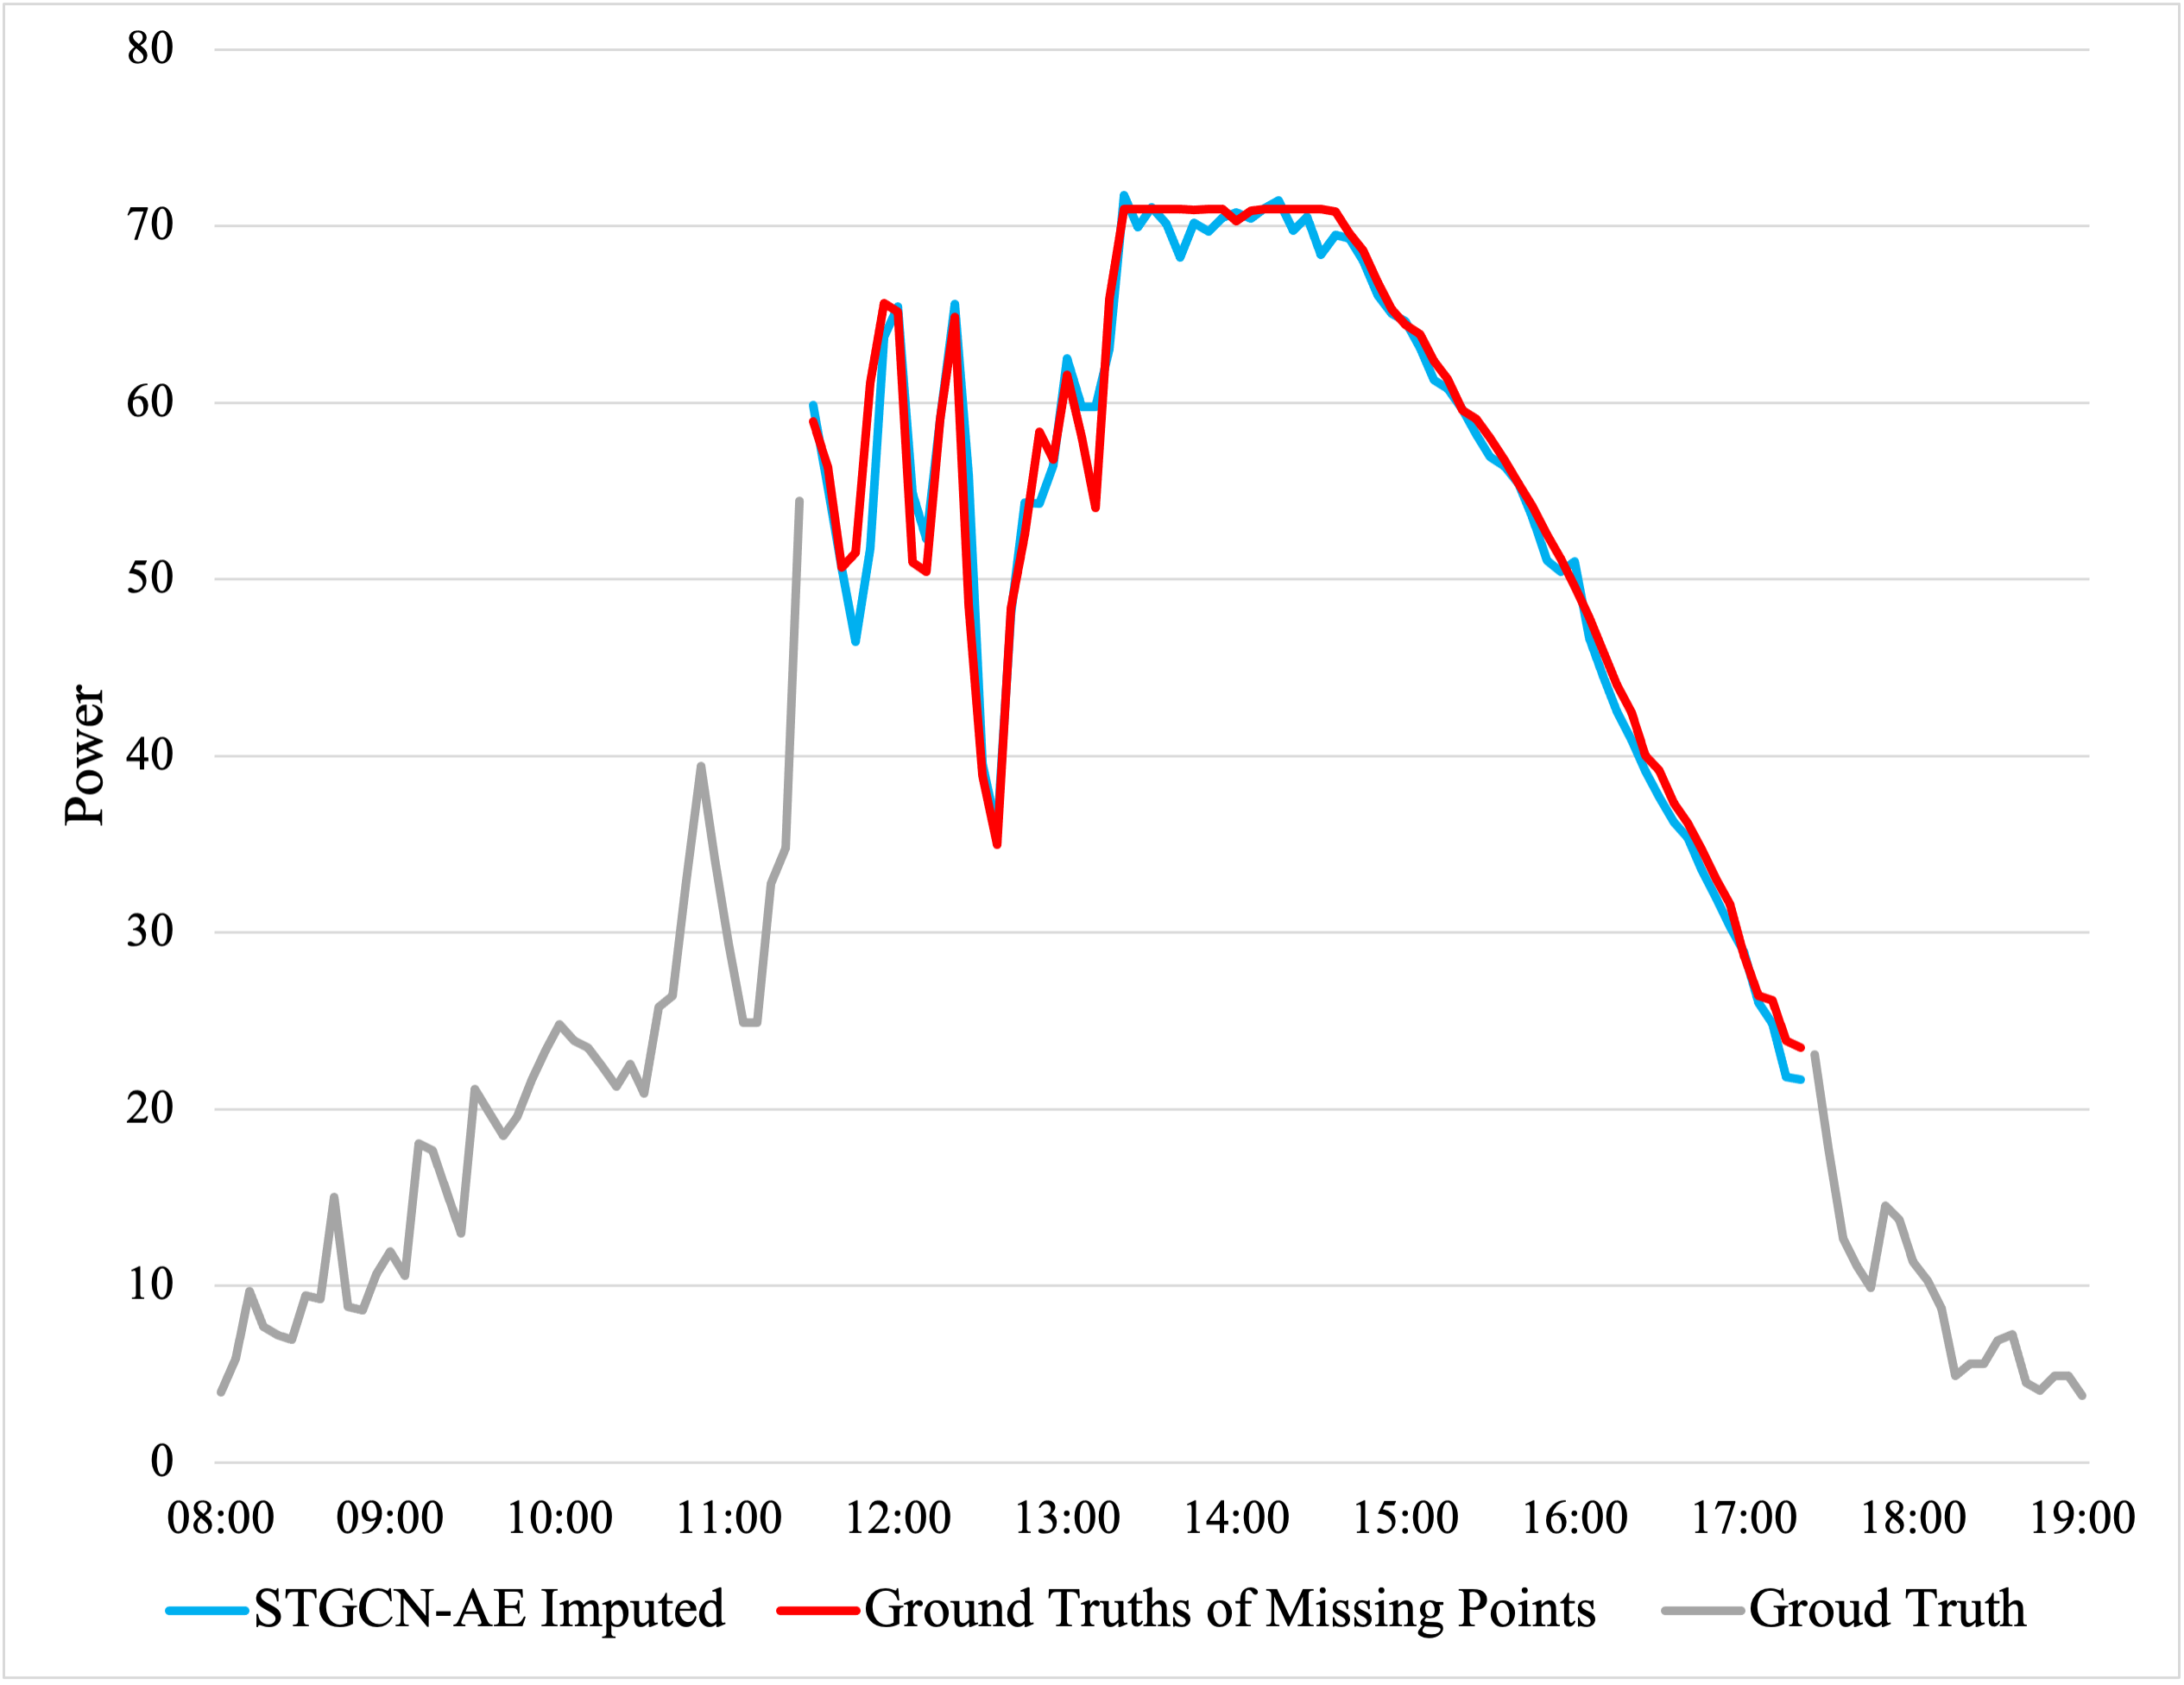

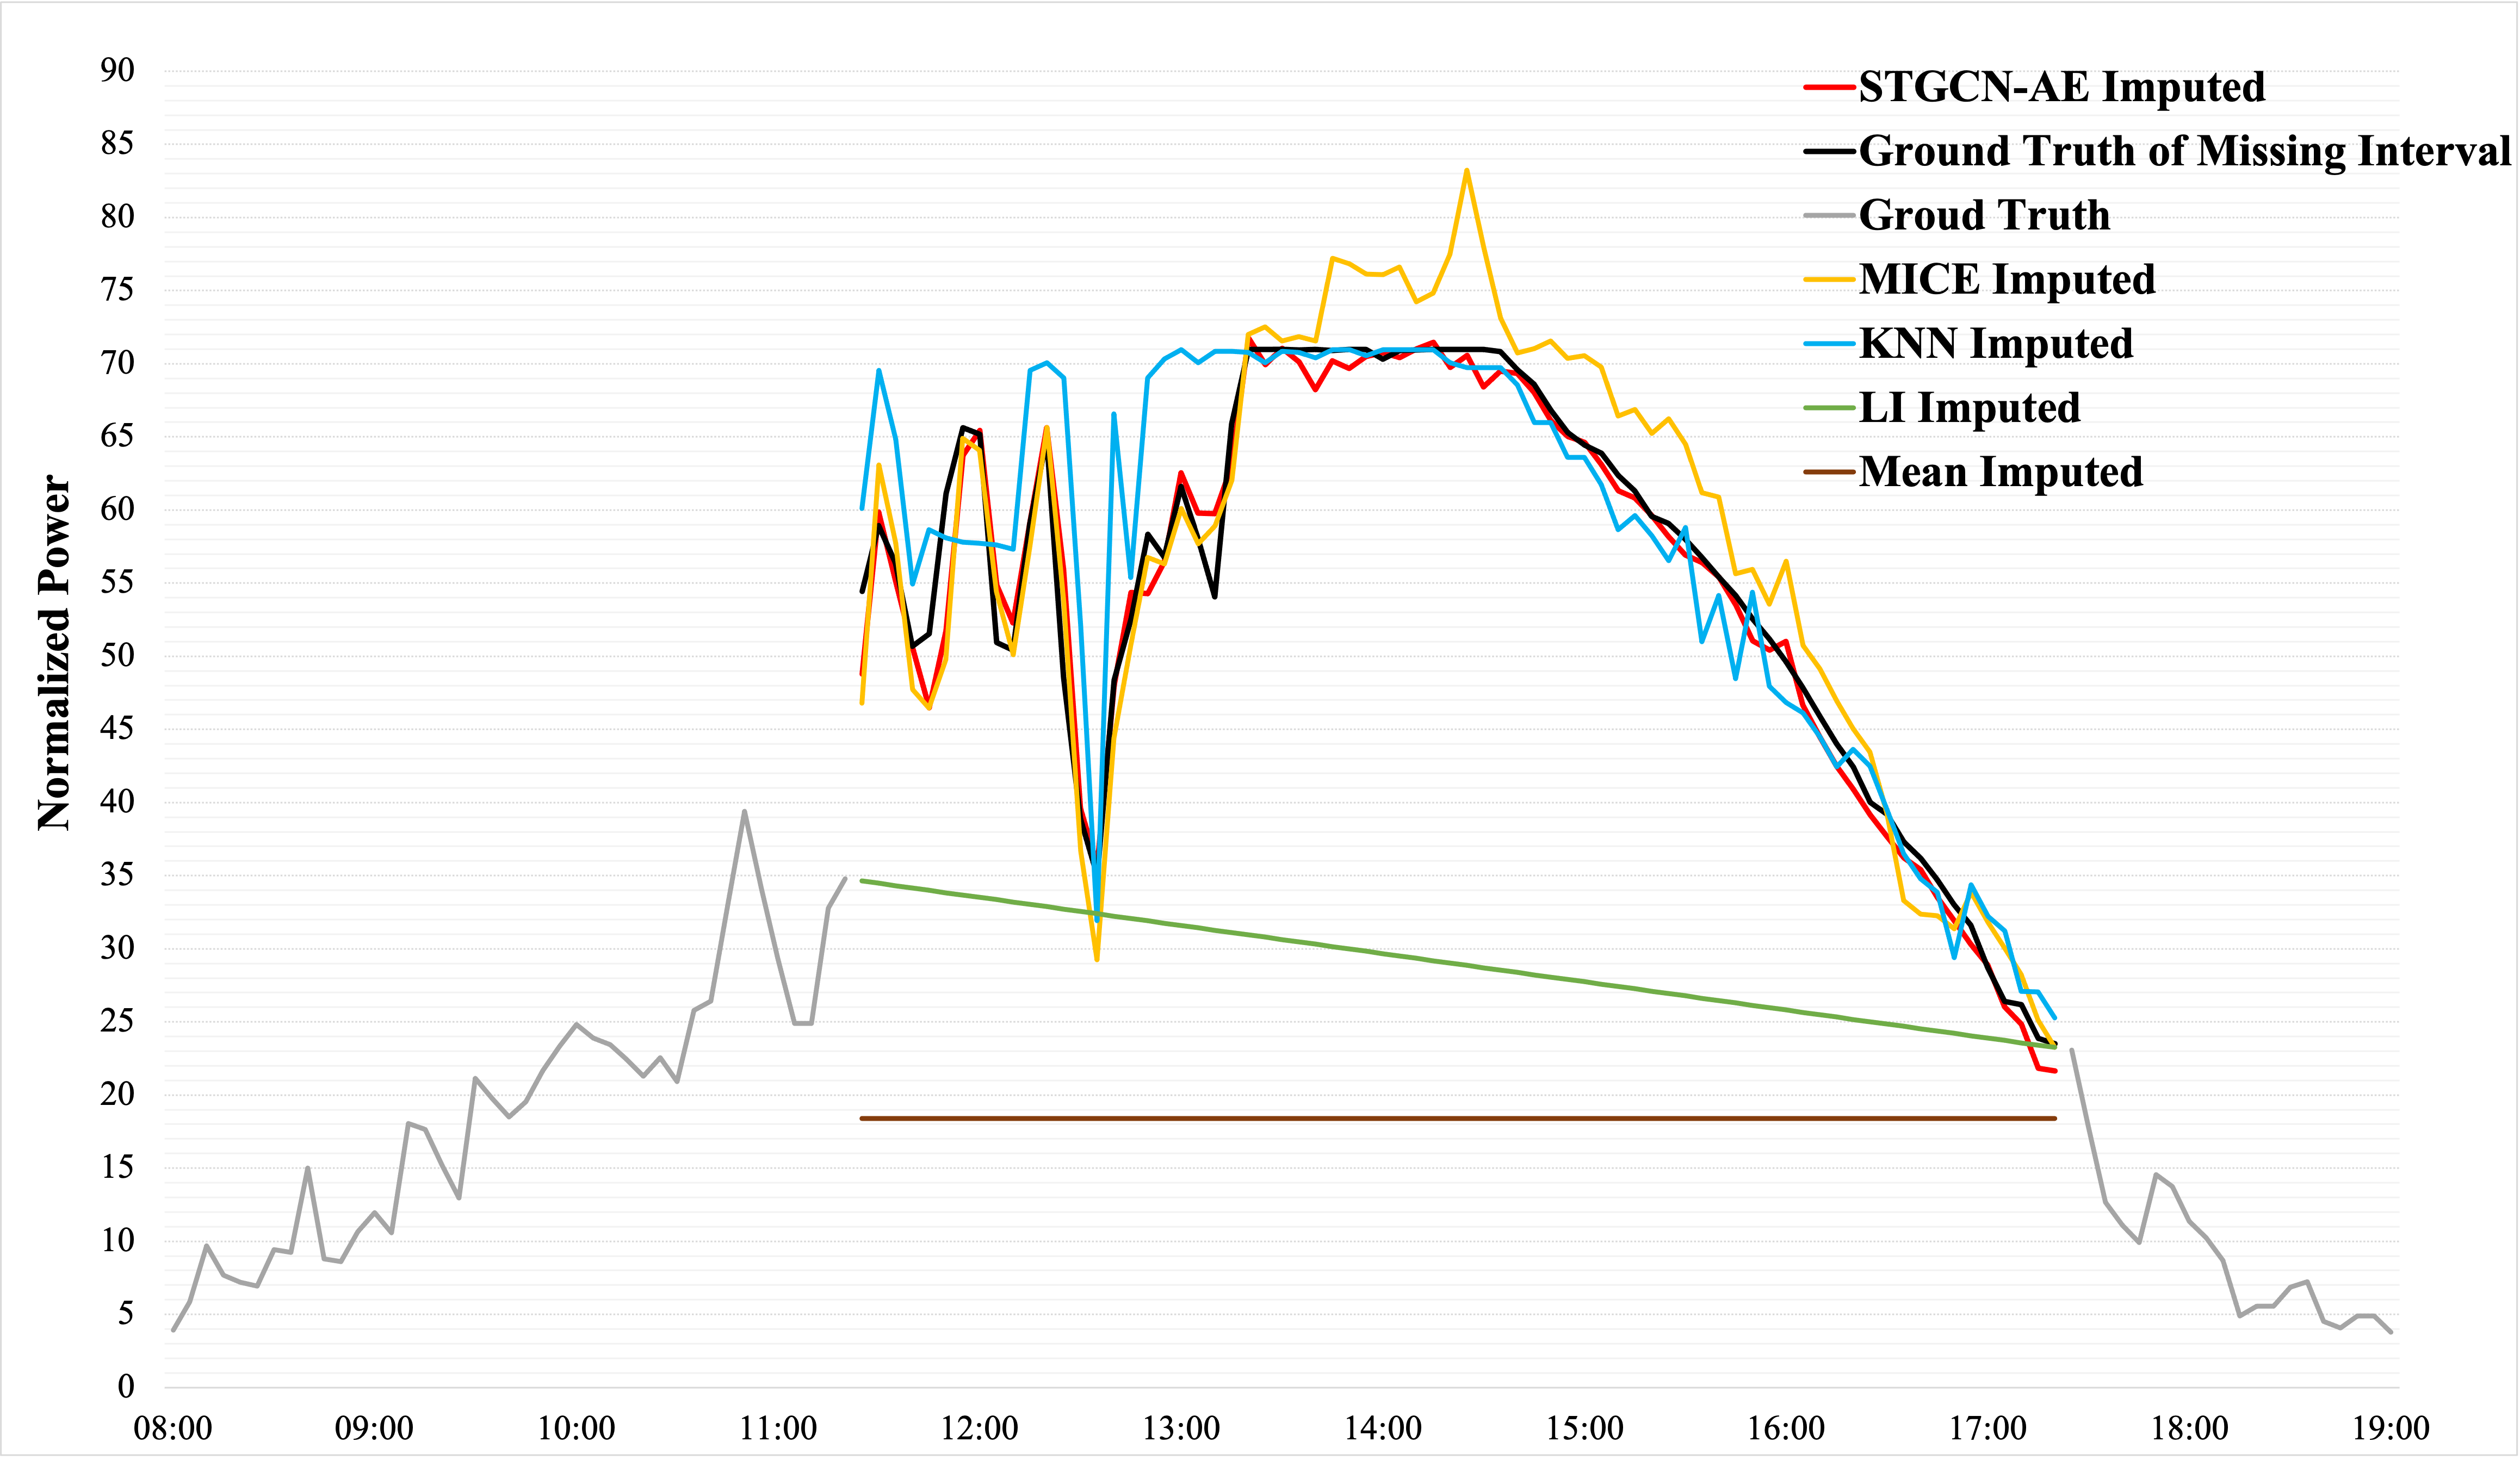

	
Here is the testing performance of STGCN-AE vs. Baseline on 6-hours Block Missing Imputation for PV inverter "c24999o" on 06/26/2016 (1st day in the testing dataset).

## References

California Department of Transportation. Caltrans Performance Measurement System (PeMS). URL: https://pems.dot.ca.gov/ [last accessed December 7, 2021]

Charles R. Harris et al. "Array programming with NumPy". In: Nature 585.7825 (Sept. 2020), pp. 357–362.DOI:10.1038/s41586–020–2649–2. URL: https://doi.org/10.1038/s41586-020-2649-2.

Fey, M., Lenssen, J. Fast Graph Representation Learning with PyTorch Geometric. (2019) arXiv:1903.02428.

The pandas development team.pandas-dev/pandas: Pandas. Version latest. Feb. 2020. DOI: 10.5281/zenodo.3509134. URL: https://doi.org/10.5281/zenodo.3509134.

Adam Paszke et al. "PyTorch: An Imperative Style, High-Performance Deep Learning Library". In: Advances inNeural Information Processing Systems 32. Ed. by H. Wallach et al. Curran Associates, Inc., 2019, pp. 8024–8035. URL:http://papers.neurips.cc/paper/9015- pytorch- an- imperative- style- high-performance-deep-learning-library.pdf.

Rozemberczki, B., Scherer, P., He, Y., Panagopoulos, G., Riedel, A., Astefanoaei, M., Kiss, O., Beres, F., Lopez, G., Collignon, N., and Sarkar, R. PyTorch Geometric Temporal: Spatiotemporal SignalProcessing with Neural Machine Learning Models. In Proceedings of the 30th ACM International Conference on Information and Knowledge Management (2021), p. 4564-4573.

Vivek, S. (2021, November 25). Visualizing real-time traffic patterns using here Traffic Api. Medium. Retrieved December 9, 2021, from https://towardsdatascience.com/visualizing-real-time-traffic-patterns-using-here-traffic-api-5f61528d563.

Yu, B., Yin, H., and Zhu, Z. Spatio-Temporal Graph Convolutional Networks: A Deep Learning Framework for Traffic Forecasting. arXiv e-prints (Sept. 2017), arXiv:1709.04875.

Yu, B., Yin, H., and Zhu, Z. (April 28, 2019). Spatio-Temporal Graph Convolutional Networks: A Deep Learning Framework for Traffic Forecasting [electronic resource: python source code (GitHub repository)]. URL:https://github.com/VeritasYin/STGCN_IJCAI-18